In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [187]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [237]:
# Load full Data
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0)
y = df_full.time_to_reservation
df_full.drop(columns=['time_to_reservation'], inplace=True)
weather_var = list(df_full.columns[-22:-1])

## Simple network

In [238]:
df = df_full.drop(columns=['index','hour_index', 'dist_to_station', 'degree']+weather_var, inplace = False)
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,30,0,1.000000,0.000364,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,86,0,0.999999,0.001018,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0.999997,0.002327,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,0,0.999968,0.007999,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32,0,0.999957,0.009236,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,0,0.999934,-0.011490,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326588,59,0,0.999970,-0.007708,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326589,48,0,0.999980,-0.006327,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326590,23,0,0.999990,-0.004363,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [239]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [240]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(269,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,16),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=269, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 18337


In [241]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.01) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.262726 , Valid Loss 17.952131 ,Train R2 0.151430, Valid R2 0.147494
Epoch 11: Train Loss 17.807641 , Valid Loss 17.431888 ,Train R2 0.176101, Valid R2 0.172199
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 21: Train Loss 17.804672 , Valid Loss 17.586493 , Train R2 0.169264, Valid R2 0.164857


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

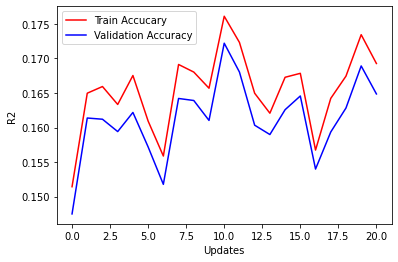

In [242]:
# setting hyperparameters and gettings epoch sizes
batch_size = 64
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

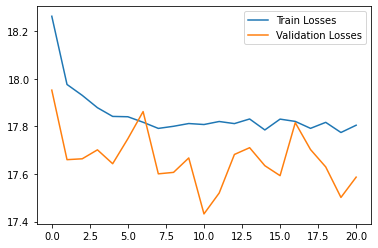

0.16457637101951694


In [243]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

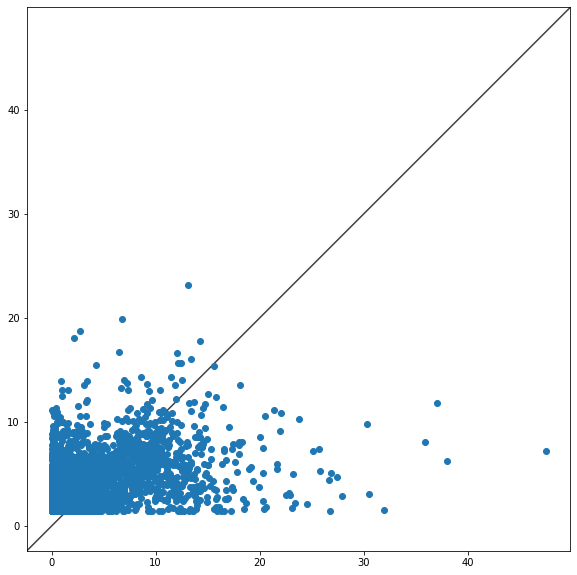

In [234]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## No Zones

In [11]:
df = df_full.iloc[:,:11]
df.drop(columns = ['degree','index','hour_index'], inplace = True)
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1
0,30,0,1.000000,0.000364,0,0,1,0
1,86,0,0.999999,0.001018,0,0,1,0
2,4,0,0.999997,0.002327,1,0,0,0
3,30,0,0.999968,0.007999,0,0,1,0
4,32,0,0.999957,0.009236,0,1,0,0
...,...,...,...,...,...,...,...,...
326587,94,0,0.999934,-0.011490,0,0,1,0
326588,59,0,0.999970,-0.007708,1,0,0,0
326589,48,0,0.999980,-0.006327,1,0,0,0
326590,23,0,0.999990,-0.004363,0,0,1,0


In [12]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [13]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(8,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.0),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.0),
            nn.Linear(128,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
) 35329


In [14]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.01) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 19.778882 , Valid Loss 19.104002 ,Train R2 0.101537, Valid R2 0.100856
Epoch 11: Train Loss 18.788129 , Valid Loss 18.853830 ,Train R2 0.114084, Valid R2 0.112631
Epoch 21: Train Loss 18.744519 , Valid Loss 18.824816 ,Train R2 0.115520, Valid R2 0.113996
Epoch 31: Train Loss 18.724043 , Valid Loss 18.804077 ,Train R2 0.116515, Valid R2 0.114972
Epoch 41: Train Loss 18.716361 , Valid Loss 18.807250 ,Train R2 0.116581, Valid R2 0.114823
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 49: Train Loss 18.719008 , Valid Loss 18.792146 , Train R2 0.116942, Valid R2 0.115534


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

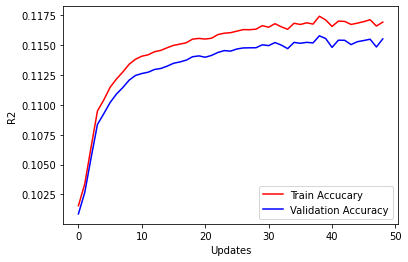

In [15]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

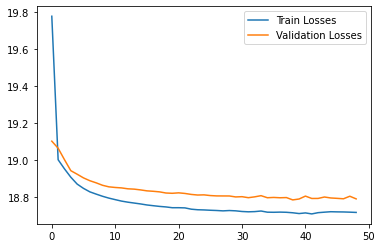

0.11550084563160035


In [16]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

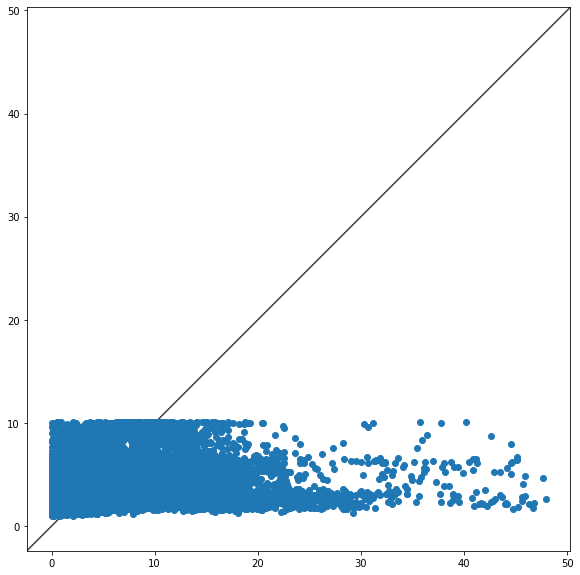

In [17]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With embedding

In [18]:
df = df_full.drop(columns=['dist_to_station', 'degree', 'index', 'hour_index']+weather_var, inplace = False)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,Zone
0,30,0,1.000000,0.000364,0,0,1,0,209
1,86,0,0.999999,0.001018,0,0,1,0,138
2,4,0,0.999997,0.002327,1,0,0,0,56
3,30,0,0.999968,0.007999,0,0,1,0,235
4,32,0,0.999957,0.009236,0,1,0,0,75
...,...,...,...,...,...,...,...,...,...
326587,94,0,0.999934,-0.011490,0,0,1,0,63
326588,59,0,0.999970,-0.007708,1,0,0,0,45
326589,48,0,0.999980,-0.006327,1,0,0,0,75
326590,23,0,0.999990,-0.004363,0,0,1,0,148


In [19]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [20]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(8+emb_dim,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 4)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 4)
  (seq): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 45589


In [21]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.0005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 20.334611 , Valid Loss 18.556056 ,Train R2 0.128303, Valid R2 0.128825
Epoch 11: Train Loss 17.011770 , Valid Loss 16.693674 ,Train R2 0.222509, Valid R2 0.216261
Epoch 21: Train Loss 16.794006 , Valid Loss 16.630151 ,Train R2 0.228192, Valid R2 0.219243
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 16.694913 , Valid Loss 16.604313 ,Train R2 0.233221, Valid R2 0.220456
Epoch 41: Train Loss 16.658108 , Valid Loss 16.579257 ,Train R2 0.235840, Valid R2 0.221633
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 49: Train Loss 16.634733 , Valid Loss 16.591725 , Train R2 0.237875, Valid R2 0.221047


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

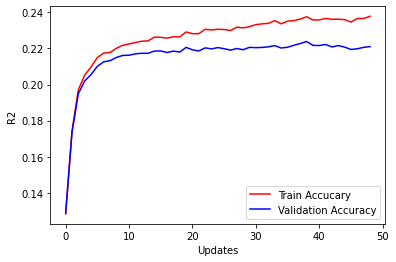

In [22]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

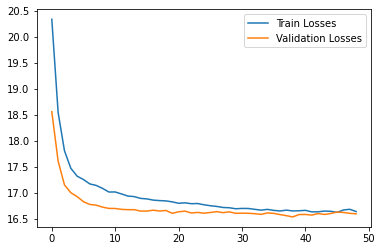

0.21631324133539576


In [23]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

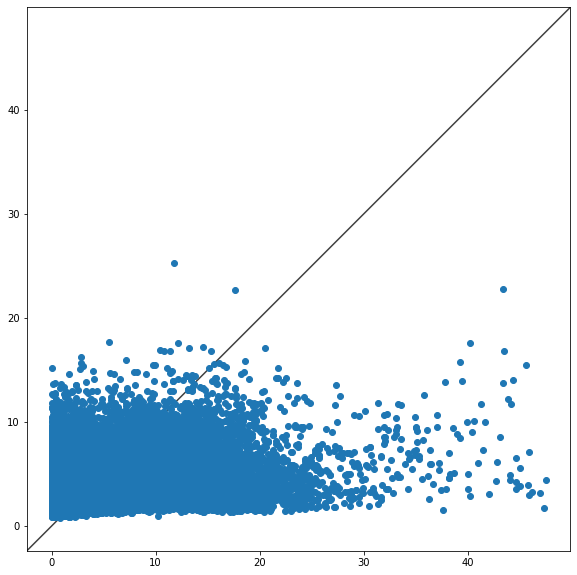

In [24]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With degree

In [25]:
df = df_full.drop(columns=['dist_to_station', 'index', 'hour_index']+weather_var, inplace = False)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [27]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(270,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            #nn.Linear(64,64),
            #nn.ReLU(),#nn.BatchNorm1d(128)),
            #nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=270, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
) 43009


In [28]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.803276 , Valid Loss 16.988710 ,Train R2 0.218040, Valid R2 0.213449
Epoch 11: Train Loss 15.913172 , Valid Loss 16.374652 ,Train R2 0.269547, Valid R2 0.241879
Epoch 21: Train Loss 15.622203 , Valid Loss 16.275937 ,Train R2 0.284915, Valid R2 0.246449
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 15.519540 , Valid Loss 16.252809 ,Train R2 0.293113, Valid R2 0.247520
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 15.504115 , Valid Loss 16.334328 ,Train R2 0.292746, Valid R2 0.243746
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 42: Train Loss 15.440470 , Valid Loss 16.334798 , Train R2 0.294639, Valid R2 0.243724


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

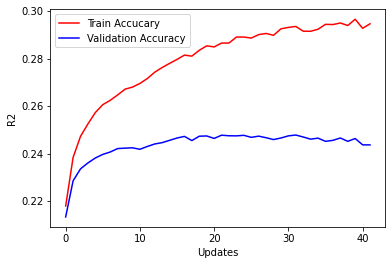

In [29]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

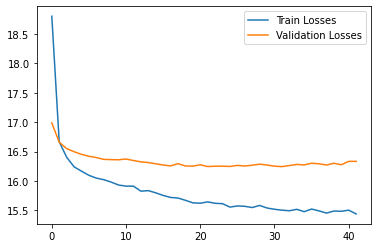

0.2409114816027198


In [30]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

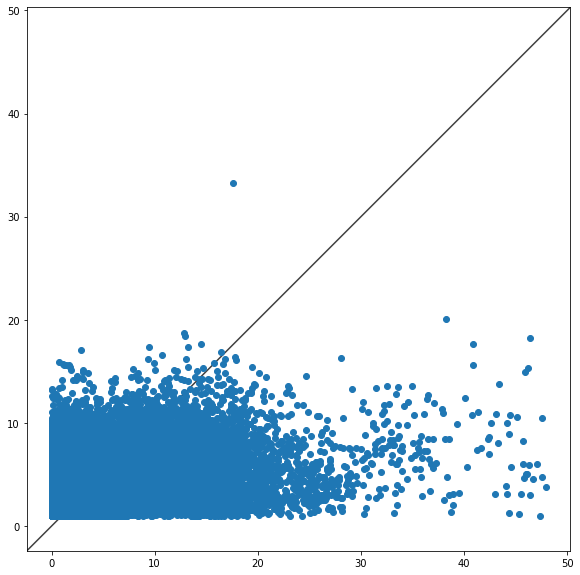

In [31]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Dist to Station

In [32]:
df = df_full.drop(columns=weather_var+['degree', 'index', 'hour_index'], inplace = False)
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,30,0,1.000000,0.000364,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,386.856080
1,86,0,0.999999,0.001018,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1096.295483
2,4,0,0.999997,0.002327,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,812.660741
3,30,0,0.999968,0.007999,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,897.592806
4,32,0,0.999957,0.009236,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,0,0.999934,-0.011490,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,275.431500
326588,59,0,0.999970,-0.007708,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,546.398658
326589,48,0,0.999980,-0.006327,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,615.556913
326590,23,0,0.999990,-0.004363,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,495.570805


In [33]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [34]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(270,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=270, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 25729


In [35]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 20.318735 , Valid Loss 17.545275 ,Train R2 0.177216, Valid R2 0.175390
Epoch 11: Train Loss 16.665240 , Valid Loss 16.511253 ,Train R2 0.243948, Valid R2 0.223988
Epoch 21: Train Loss 16.410129 , Valid Loss 16.465497 ,Train R2 0.254564, Valid R2 0.226138
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 16.278587 , Valid Loss 16.496352 ,Train R2 0.260062, Valid R2 0.224688
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 34: Train Loss 16.249237 , Valid Loss 16.474781 , Train R2 0.262694, Valid R2 0.225702


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

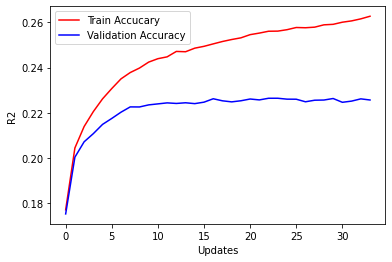

In [36]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

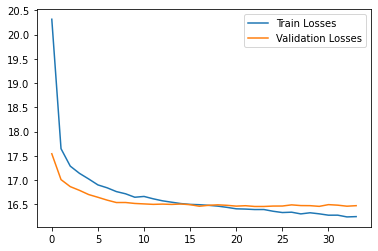

0.21962519305678263


In [37]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

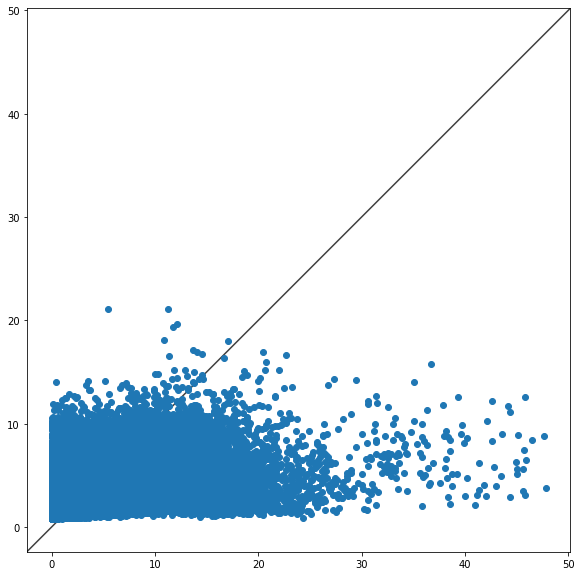

In [38]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With both

In [104]:
df = df_full.drop(columns=['index','hour_index']+weather_var, inplace = False)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,495.570805


In [105]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [134]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(271,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(128,32),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(32,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=271, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
) 38977


In [135]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 27.233438 , Valid Loss 20.484901 ,Train R2 0.025559, Valid R2 0.026146
Epoch 11: Train Loss 16.715632 , Valid Loss 16.372388 ,Train R2 0.233499, Valid R2 0.221655
Epoch 21: Train Loss 16.085039 , Valid Loss 15.928679 ,Train R2 0.263821, Valid R2 0.242749
Epoch 31: Train Loss 15.802023 , Valid Loss 15.797672 ,Train R2 0.280088, Valid R2 0.248977
Epoch 41: Train Loss 15.636220 , Valid Loss 15.723208 ,Train R2 0.291218, Valid R2 0.252517
Epoch 51: Train Loss 15.414765 , Valid Loss 15.683103 ,Train R2 0.299249, Valid R2 0.254424
Epoch 61: Train Loss 15.299440 , Valid Loss 15.646632 ,Train R2 0.305779, Valid R2 0.256158
Epoch 71: Train Loss 15.202401 , Valid Loss 15.619140 ,Train R2 0.310787, Valid R2 0.257465
EarlyStopping counter: 5 out of 10
Epoch 81: Train Loss 15.127180 , Valid Loss 15.620213 ,Train R2 0.315517, Valid R2 0.257414
EarlyStopping counter: 5 out of 10
Epoch 91: Train Loss 15.100142 , Valid Loss 15.599354 ,Train R2 0.318424, Valid R2 0.258405
Epoch 101:

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

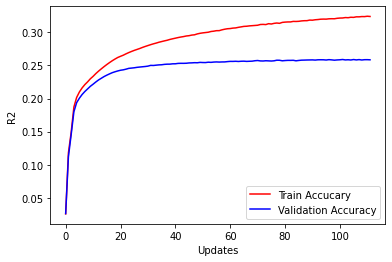

In [136]:
# setting hyperparameters and gettings epoch sizes
batch_size = 21772
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

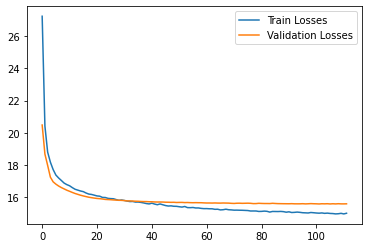

0.2565594084113204


In [137]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

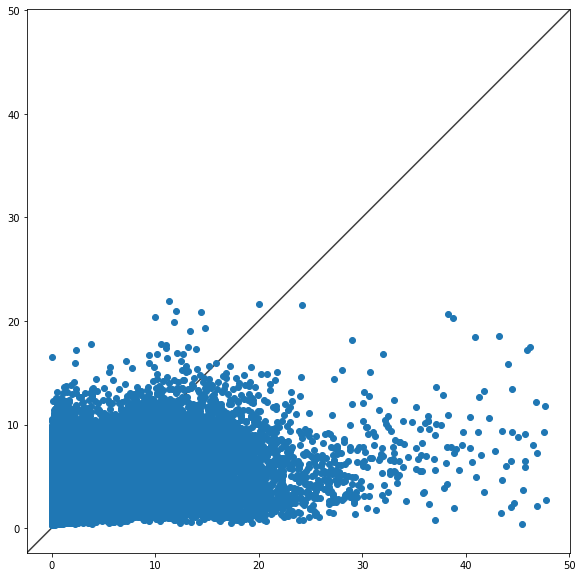

In [138]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With weather

In [146]:
df = df_full.drop(['index','hour_index']+list(df_full.filter(regex='Avg').columns),axis=1)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185154,lz_185203,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,495.570805


In [147]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [171]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(278,32),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.1),
            nn.Linear(32,16),
            nn.ReLU(),#nn.BatchNorm1d(16)),
            nn.Dropout(0.1),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=278, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 9473


In [172]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.00005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 24.608011 , Valid Loss 24.454792 ,Train R2 -0.158870, Valid R2 -0.154582
Epoch 11: Train Loss 16.518978 , Valid Loss 16.620092 ,Train R2 0.222068, Valid R2 0.215317
Epoch 21: Train Loss 15.949833 , Valid Loss 16.204985 ,Train R2 0.248871, Valid R2 0.234916
Epoch 31: Train Loss 15.664826 , Valid Loss 16.087976 ,Train R2 0.262293, Valid R2 0.240440
Epoch 41: Train Loss 15.499734 , Valid Loss 16.067599 ,Train R2 0.270068, Valid R2 0.241402
Epoch 51: Train Loss 15.398767 , Valid Loss 16.051881 ,Train R2 0.274823, Valid R2 0.242144
EarlyStopping counter: 5 out of 10
Epoch 61: Train Loss 15.321427 , Valid Loss 16.051244 ,Train R2 0.278465, Valid R2 0.242174
EarlyStopping counter: 5 out of 10
Epoch 71: Train Loss 15.242713 , Valid Loss 16.045825 ,Train R2 0.282172, Valid R2 0.242430
Epoch 81: Train Loss 15.142495 , Valid Loss 15.996802 ,Train R2 0.286891, Valid R2 0.244745
Epoch 91: Train Loss 15.055182 , Valid Loss 15.951825 ,Train R2 0.291003, Valid R2 0.246868
Epoch 10

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

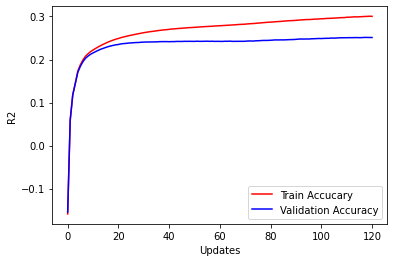

In [173]:
# setting hyperparameters and gettings epoch sizes
batch_size = 21772
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

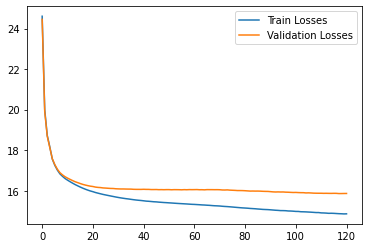

0.2513366875986619


In [174]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

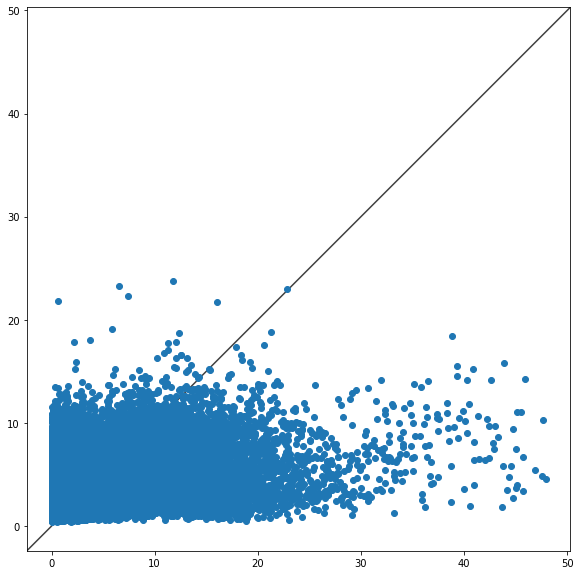

In [175]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## Average weather (cheat)

In [55]:
df = df_full.drop(['index','hour_index']+weather_var[:7]+weather_var[-7:],axis=1)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185154,lz_185203,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333,495.570805


In [56]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [57]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(278,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.33),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.33),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.33),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=278, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.33, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.33, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.33, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 112641


In [58]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 15.000846 , Valid Loss 15.313635 ,Train R2 0.293879, Valid R2 0.288012
Epoch 11: Train Loss 8.526853 , Valid Loss 10.589654 ,Train R2 0.598623, Valid R2 0.507648
Epoch 21: Train Loss 6.971429 , Valid Loss 9.780583 ,Train R2 0.671840, Valid R2 0.545264
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 6.117869 , Valid Loss 9.392233 ,Train R2 0.712019, Valid R2 0.563320
Epoch 41: Train Loss 5.420890 , Valid Loss 8.898162 ,Train R2 0.744828, Valid R2 0.586291
Epoch 51: Train Loss 5.137084 , Valid Loss 8.658154 ,Train R2 0.758187, Valid R2 0.597450
Epoch 61: Train Loss 4.689697 , Valid Loss 8.329711 ,Train R2 0.779246, Valid R2 0.612721
Epoch 71: Train Loss 4.353078 , Valid Loss 7.985601 ,Train R2 0.795092, Valid R2 0.628720
EarlyStopping counter: 5 out of 10
Epoch 81: Train Loss 4.186238 , Valid Loss 7.822459 ,Train R2 0.802945, Valid R2 0.636305
EarlyStopping counter: 5 out of 10
Epoch 91: Train Loss 3.890999 , Valid Loss 7.565300 ,Train R2 0.816843, Valid R2 0

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

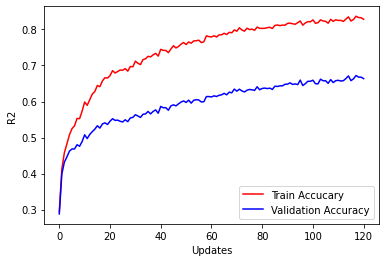

In [59]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

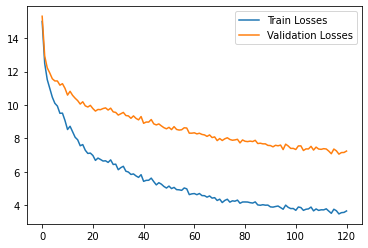

0.6571519812393656


In [60]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

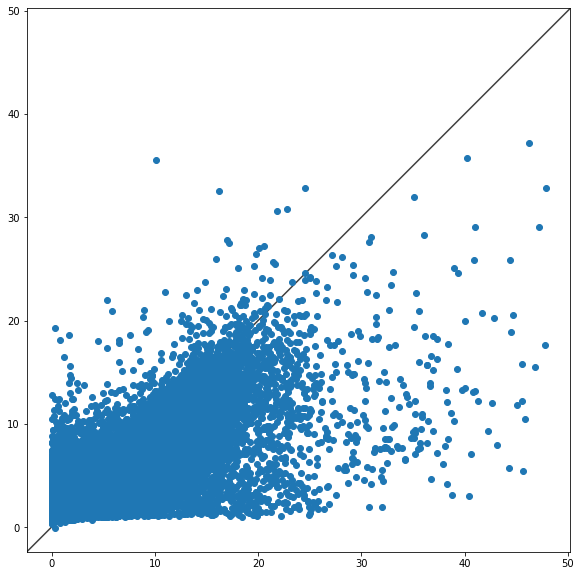

In [61]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## Only average weather

In [62]:
df_w = df_full[weather_var[7:14]+['dist_to_station']]
df_w

,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover,dist_to_station
0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444,386.856080
1,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,1096.295483
2,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,812.660741
3,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667,897.592806
4,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429,599.103807
...,...,...,...,...,...,...,...,...
326587,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143,275.431500
326588,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,546.398658
326589,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,615.556913
326590,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333,495.570805


In [63]:
train_val, test_data, y_train_val, y_test = train_test_split(df_w, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [64]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(8,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.25),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.25),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.25),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 43521


In [65]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 19.140189 , Valid Loss 19.868999 ,Train R2 0.091059, Valid R2 0.083325
Epoch 11: Train Loss 10.910947 , Valid Loss 11.328669 ,Train R2 0.481854, Valid R2 0.477341
Epoch 21: Train Loss 8.465648 , Valid Loss 8.948875 ,Train R2 0.597978, Valid R2 0.587135
Epoch 31: Train Loss 7.426853 , Valid Loss 7.937275 ,Train R2 0.647309, Valid R2 0.633806
Epoch 41: Train Loss 6.688150 , Valid Loss 7.199268 ,Train R2 0.682389, Valid R2 0.667855
Epoch 51: Train Loss 6.187595 , Valid Loss 6.697354 ,Train R2 0.706160, Valid R2 0.691011
EarlyStopping counter: 5 out of 10
Epoch 61: Train Loss 6.124537 , Valid Loss 6.630564 ,Train R2 0.709154, Valid R2 0.694093
Epoch 71: Train Loss 5.608017 , Valid Loss 6.082148 ,Train R2 0.733683, Valid R2 0.719394
EarlyStopping counter: 5 out of 10
Epoch 81: Train Loss 5.398868 , Valid Loss 5.888593 ,Train R2 0.743615, Valid R2 0.728324
Epoch 91: Train Loss 5.418266 , Valid Loss 5.932046 ,Train R2 0.742694, Valid R2 0.726320
Epoch 101: Train Loss 5.03

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

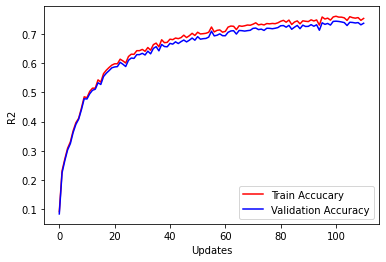

In [66]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

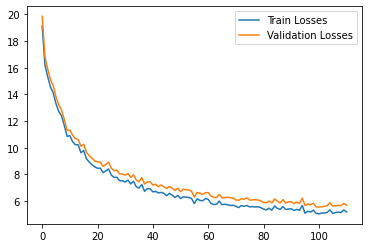

0.7375942516927064


In [67]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

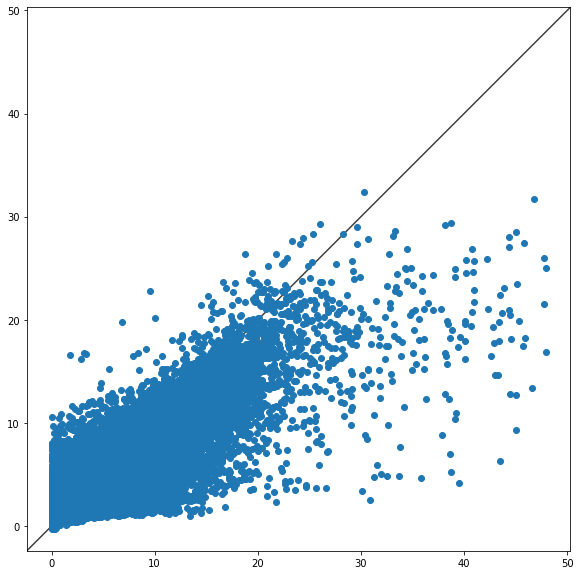

In [68]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With weather (index)

In [69]:
df = df_full.drop(['index','hour_index']+weather_var[:14],axis=1)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185154,lz_185203,Avg_Index_mean_temp,Avg_Index_mean_wind_speed,Avg_Index_acc_precip,Avg_Index_bright_sunshine,Avg_Index_mean_pressure,Avg_Index_mean_relative_hum,Avg_Index_mean_cloud_cover,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,495.570805


In [70]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [71]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(278,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.4),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.4),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.4),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=278, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 26241


In [72]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0004) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 17.290421 , Valid Loss 17.589298 ,Train R2 0.184043, Valid R2 0.175361
Epoch 11: Train Loss 15.486475 , Valid Loss 16.244855 ,Train R2 0.269174, Valid R2 0.238392
Epoch 21: Train Loss 15.240577 , Valid Loss 16.188472 ,Train R2 0.280778, Valid R2 0.241036
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 15.088566 , Valid Loss 16.200694 ,Train R2 0.287951, Valid R2 0.240463
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 33: Train Loss 15.098612 , Valid Loss 16.223850 , Train R2 0.287477, Valid R2 0.239377


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

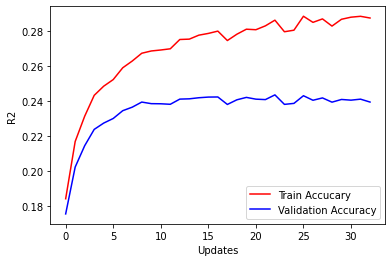

In [73]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

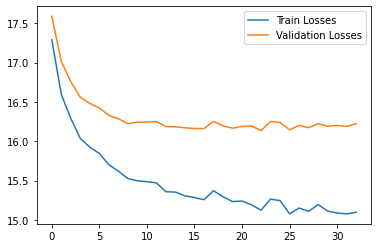

0.24744489048846574


In [74]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

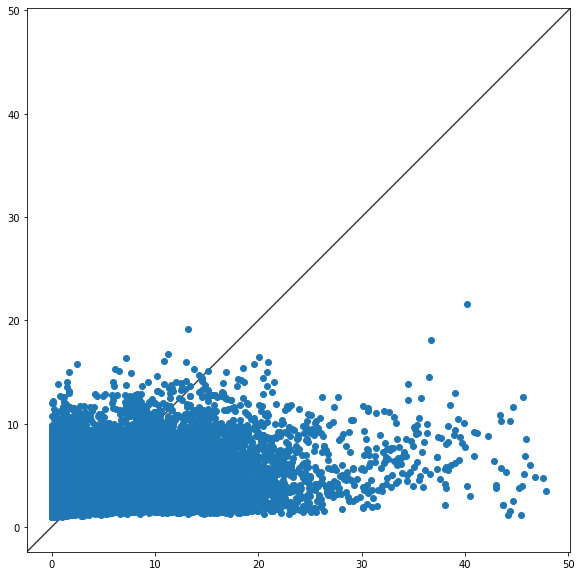

In [75]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With weather and embedding

In [176]:
df = df_full.drop(df_full.filter(regex='Avg').columns,axis=1)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df = df.drop(columns = ['hour_index', 'index'])
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station,Zone
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,386.856080,209
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,1096.295483,138
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,812.660741,56
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,897.592806,235
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,599.103807,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,275.431500,63
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,546.398658,45
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,615.556913,75
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,495.570805,148


In [177]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [182]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(17+emb_dim,32),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(32,16),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            #nn.Linear(128,64),
            #nn.ReLU(),#nn.BatchNorm1d(64)),
            #nn.Dropout(0.2),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 4)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 4)
  (seq): Sequential(
    (0): Linear(in_features=21, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 2293


In [183]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.885530 , Valid Loss 18.865121 ,Train R2 0.112114, Valid R2 0.104238
Epoch 11: Train Loss 16.334917 , Valid Loss 16.504119 ,Train R2 0.232029, Valid R2 0.216344
Epoch 21: Train Loss 15.986060 , Valid Loss 16.215166 ,Train R2 0.248430, Valid R2 0.230064
Epoch 31: Train Loss 15.837768 , Valid Loss 16.083352 ,Train R2 0.255402, Valid R2 0.236323
Epoch 41: Train Loss 15.770956 , Valid Loss 16.029238 ,Train R2 0.258543, Valid R2 0.238892
Epoch 51: Train Loss 15.690118 , Valid Loss 15.973408 ,Train R2 0.262343, Valid R2 0.241543
EarlyStopping counter: 5 out of 10
Epoch 61: Train Loss 15.634669 , Valid Loss 15.941993 ,Train R2 0.264950, Valid R2 0.243035
EarlyStopping counter: 5 out of 10
Epoch 71: Train Loss 15.582442 , Valid Loss 15.904837 ,Train R2 0.267406, Valid R2 0.244799
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 75: Train Loss 15.621210 , Valid Loss 15.932058 , Train R2 0.265583, Valid R2 0.243507


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

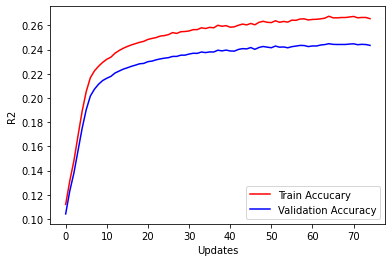

In [184]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

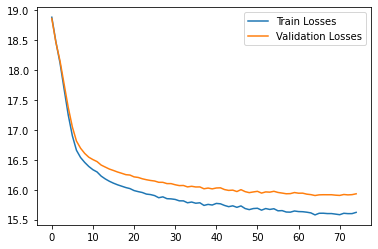

0.2524669387312096
0.02915464589472838


In [185]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))
print(r2_score(np.log(y_test.detach().numpy()[:,0]),np.log(net.forward(X_test).detach().numpy()[:,0])))

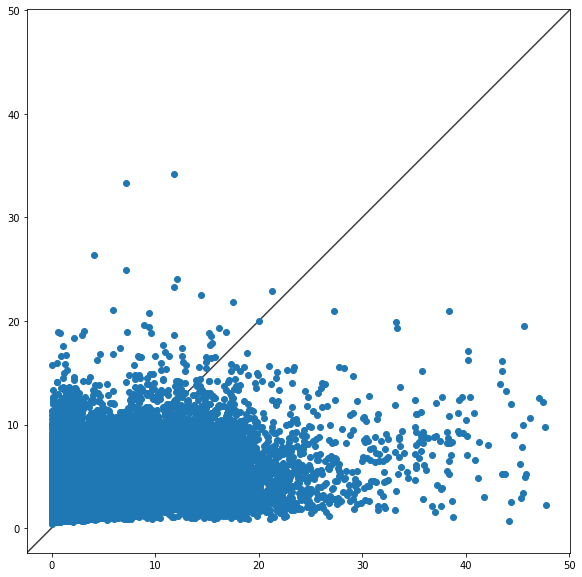

In [82]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

In [83]:
net.forward(X_test).detach().numpy()[:,0].argsort()[::-1]

array([21710, 18392, 64774, ...,  4085, 33978,  6373])

In [84]:
net.forward(X_test).detach().numpy()[:,0][9057]

4.0994263

In [85]:
test_data.iloc[9057]

leave_fuel             1.428145
degree                -0.197623
Time_Cos              -0.231920
Time_Sin               1.859402
mean_temp              0.261059
mean_wind_speed       -1.185764
acc_precip            -0.257272
bright_sunshine       -0.537203
mean_pressure         -2.219106
mean_relative_hum      1.242207
mean_cloud_cover       0.866368
dist_to_station       -0.416388
weekend                0.000000
eng_118I               0.000000
eng_COOPER             0.000000
eng_I3                 1.000000
eng_X1                 0.000000
Zone                 211.000000
Name: 119113, dtype: float64

In [86]:
X_test

tensor([[ 2.4413e-01,  9.5397e-01,  1.0523e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.5700e+02],
        [ 2.4413e-01,  1.5764e+00, -2.2068e-01,  ...,  0.0000e+00,
          0.0000e+00,  5.5000e+01],
        [ 4.5556e-01,  1.6848e+00,  3.0050e-02,  ...,  1.0000e+00,
          0.0000e+00,  2.1000e+01],
        ...,
        [-1.5319e+00, -5.6910e-01, -7.3764e-01,  ...,  0.0000e+00,
          0.0000e+00,  1.8100e+02],
        [-1.3645e-01,  5.2813e-01,  8.8052e-02,  ...,  0.0000e+00,
          1.0000e+00,  1.4800e+02],
        [-2.6331e-01,  2.0098e-01,  1.1107e+00,  ...,  1.0000e+00,
          0.0000e+00,  9.3000e+01]])

## With average weather and embedding

In [87]:
df = df_full.drop(['index','hour_index']+weather_var[:14],axis=1)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,Avg_Index_mean_temp,Avg_Index_mean_wind_speed,Avg_Index_acc_precip,Avg_Index_bright_sunshine,Avg_Index_mean_pressure,Avg_Index_mean_relative_hum,Avg_Index_mean_cloud_cover,dist_to_station,Zone
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,386.856080,209
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,1096.295483,138
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,812.660741,56
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,897.592806,235
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,599.103807,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,275.431500,63
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,546.398658,45
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,615.556913,75
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,495.570805,148


In [88]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [89]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(17+emb_dim,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(128,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 8)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 8)
  (seq): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 30249


In [90]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.326287 , Valid Loss 18.478481 ,Train R2 0.139692, Valid R2 0.137120
Epoch 11: Train Loss 15.665250 , Valid Loss 16.085855 ,Train R2 0.264612, Valid R2 0.248847
Epoch 21: Train Loss 15.318487 , Valid Loss 15.947938 ,Train R2 0.280890, Valid R2 0.255287
Epoch 31: Train Loss 15.060615 , Valid Loss 15.894355 ,Train R2 0.292996, Valid R2 0.257789
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 14.842898 , Valid Loss 15.917854 ,Train R2 0.303216, Valid R2 0.256692
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 45: Train Loss 14.713470 , Valid Loss 15.940991 , Train R2 0.309292, Valid R2 0.255612


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

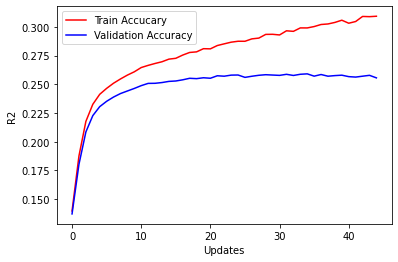

In [91]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

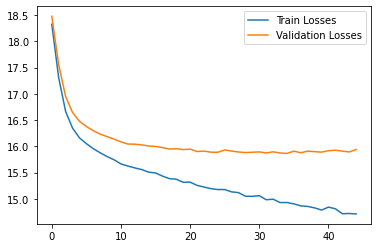

0.2518907686691628


In [92]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

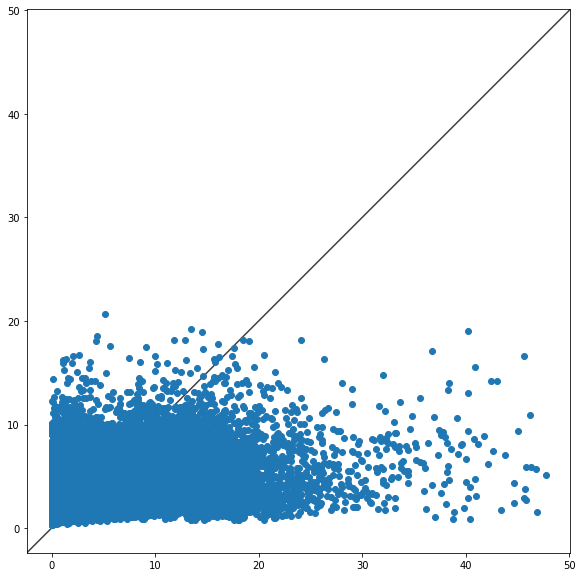

In [93]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

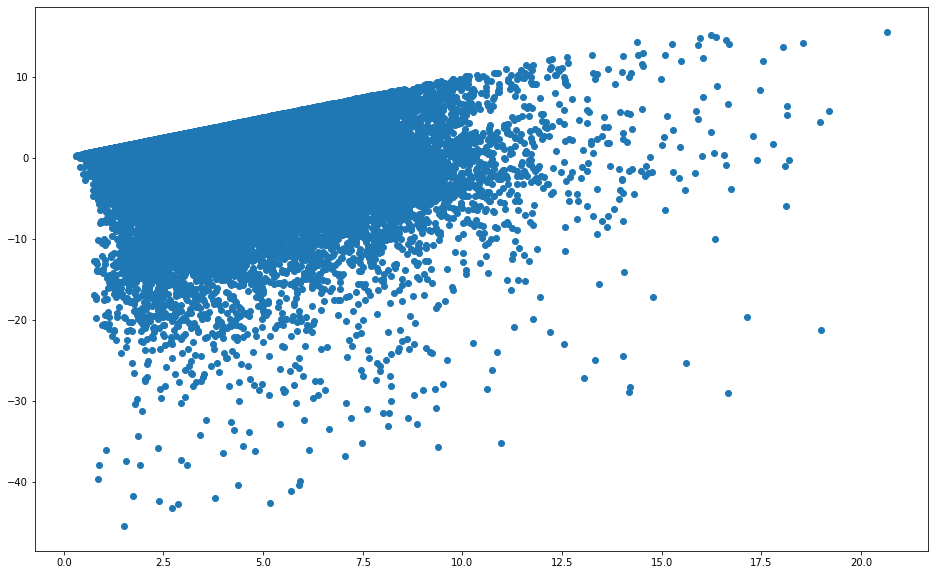

In [94]:
fig, ax = plt.subplots(figsize = (16,10))
ax.scatter(net.forward(X_test).detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])
plt.show()

In [95]:
np.corrcoef(net.forward(X_test).detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])

array([[ 1.        , -0.02946182],
       [-0.02946182,  1.        ]])

In [96]:
np.mean(net.forward(X_test).detach().numpy()[:,0]-y_test.detach().numpy()[:,0])

-0.13169987

## Embedding and cheating with weather

In [97]:
df = df_full.drop(['index','hour_index']+weather_var[:7]+weather_var[-7:],axis=1)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover,dist_to_station,Zone
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444,386.856080,209
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,1096.295483,138
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,812.660741,56
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667,897.592806,235
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429,599.103807,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143,275.431500,63
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,546.398658,45
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,615.556913,75
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333,495.570805,148


In [98]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|Zone|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|Zone|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [99]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(261,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(17+emb_dim,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(128,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 8)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(261, 8)
  (seq): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 30249


In [100]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 17.133272 , Valid Loss 17.662596 ,Train R2 0.188873, Valid R2 0.179185
Epoch 11: Train Loss 9.630902 , Valid Loss 10.105886 ,Train R2 0.544052, Valid R2 0.530360
Epoch 21: Train Loss 6.932271 , Valid Loss 7.532680 ,Train R2 0.671811, Valid R2 0.649942
Epoch 31: Train Loss 5.595223 , Valid Loss 6.355213 ,Train R2 0.735110, Valid R2 0.704661
Epoch 41: Train Loss 4.941588 , Valid Loss 5.716983 ,Train R2 0.766054, Valid R2 0.734321
Epoch 51: Train Loss 4.446912 , Valid Loss 5.313112 ,Train R2 0.789473, Valid R2 0.753089
Epoch 61: Train Loss 4.361866 , Valid Loss 5.258526 ,Train R2 0.793500, Valid R2 0.755626
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 68: Train Loss 4.218661 , Valid Loss 5.165789 , Train R2 0.800279, Valid R2 0.759936


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

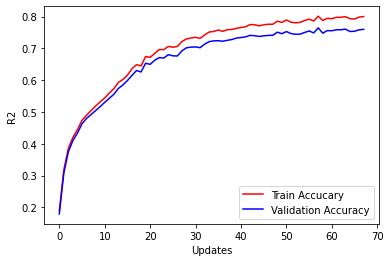

In [101]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

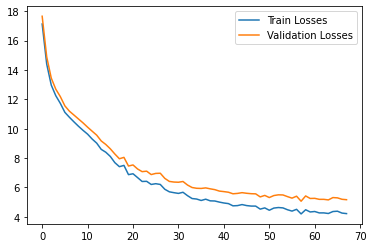

0.7568543226021369


In [102]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

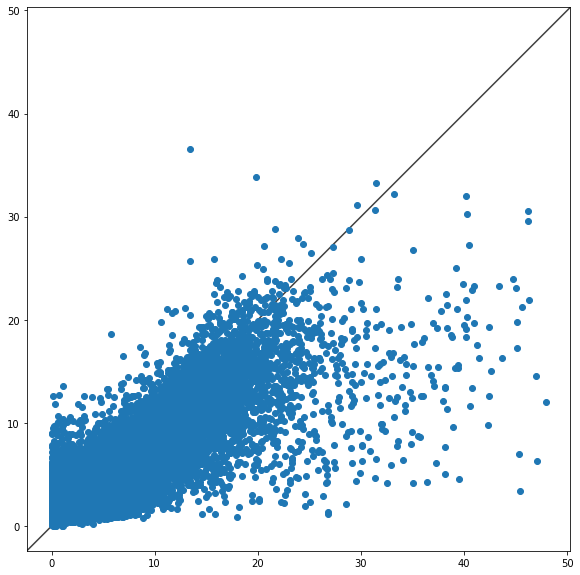

In [103]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()